# DCGAN (CelebA)

In [1]:
num_gpu = 1          # Number of GPUs available. Use 0 for CPU mode.

num_workers = 4      # Number of workers for dataloader
batch_size = 128     # Batch size during training
image_size = 64      # Spatial size of training images

num_features_g = 64  # Size of feature maps in generator
num_features_d = 64  # Size of feature maps in discriminator
z_dim = 100          # Size of z latent vector

num_epochs = 3       # Number of training epochs
lr = 0.0002          # Learning rate for optimizers
beta1 = 0.5          # Beta1 hyperparam for Adam optimizers

save_format_g = "./checkpoint/generator/epoch_{epoch:03d}.pth"
save_format_d = "./checkpoint/discriminator/epoch_{epoch:03d}.pth"

## Environment

### Import modules

In [2]:
import os

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
from torchvision import datasets, transforms

from tqdm.auto import tqdm, trange

from lib import utils

In [3]:
if torch.cuda.is_available() and num_gpu > 0:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

Device: cuda


### Make folders

In [4]:
# Create folders
os.makedirs("./data", exist_ok=True)
os.makedirs("./checkpoint/generator", exist_ok=True)
os.makedirs("./checkpoint/discriminator", exist_ok=True)
os.makedirs("./img/real", exist_ok=True)
os.makedirs("./img/fake", exist_ok=True)

### Dataset

You should download the following files from [Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8).

1. Download the following files:
    - `Anno/list_attr_celeba.txt`
    - `Anno/identity_CelebA.txt`
    - `Anno/list_bbox_celeba.txt`
    - `Anno/list_landmarks_align_celeba.txt`
    - `Eval/list_eval_partition.txt`
    - `Img/img_align_celeba.zip`
2. Make folder `celeba` under `./data/` directory.
3. Move downloaded files to `./data/celeba/` directory.
   Then extract the `img_align_celeba.zip`.
4. Final directory structure under `./data/celeba/` should be like:
    - `img_align_celeba` (directory)
    - `img_align_celeba.zip` (can be deleted)
    - `identity_CelebA.txt`
    - `list_attr_celeba.txt`
    - `list_bbox_celeba.txt`
    - `list_eval_partition.txt`
    - `list_landmarks_align_celeba.txt`


In [5]:
num_channels = 3

train_dataset = datasets.CelebA(
    root="./data", split="train",
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=num_workers,
)

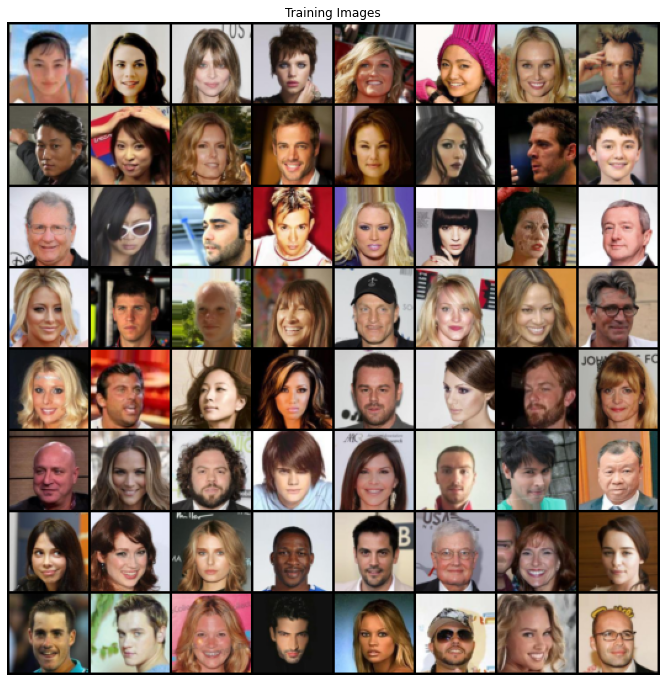

In [6]:
images = next(iter(train_loader))[0][:64]
utils.vis_images(images).show()

## Implementation

### Generator

In [7]:
class Generator(nn.Sequential):
    def __init__(self,
        z_dim: int,
        num_features: int,
        num_channels: int = 3,
    ):
        super().__init__()

        # Input: Z
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(z_dim, 1, 1))
        self.convt_block1 = self._convt_block(
            in_channels=z_dim,
            out_channels=(num_features * 8),
            stride=1, padding=0,
        )
        # State size: (ngf x 8) x 4 x 4
        self.convt_block2 = self._convt_block(
            in_channels=(num_features * 8),
            out_channels=(num_features * 4),
        )
        # State size: (ngf x 4) x 8 x 8
        self.convt_block3 = self._convt_block(
            in_channels=(num_features * 4),
            out_channels=(num_features * 2),
        )
        # State size: (ngf x 2) x 16 x 16
        self.convt_block4 = self._convt_block(
            in_channels=(num_features * 2),
            out_channels=num_features,
        )
        # State size: (ngf) x 32 x 32
        self.convt_block5 = self._convt_block(
            in_channels=num_features,
            out_channels=num_channels,
            batch_norm=False,
            act_factory=nn.Tanh,
        )
        # Output size: (nc) x 64 x 64

    @staticmethod
    def _convt_block(
        in_channels,
        out_channels,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        batch_norm: bool = True,
        act_factory = nn.ReLU,
    ):
        return nn.Sequential(
            *([nn.ConvTranspose2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=kernel_size, stride=stride,
                    padding=padding, bias=False)]
            + ([nn.BatchNorm2d(out_channels)] if batch_norm else [])
            + [act_factory()])
        )

In [8]:
generator = Generator(z_dim, num_features_g, num_channels)
print(generator)

Generator(
  (unflatten): Unflatten(dim=1, unflattened_size=(100, 1, 1))
  (convt_block1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convt_block2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convt_block3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convt_block4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

### Discriminator

In [9]:
class Discriminator(nn.Sequential):
    def __init__(self,
        z_dim: int,
        num_features: int,
        num_channels: int = 3,
    ):
        super().__init__()

        # Input size: (nc) x 64 x 64
        self.conv_block1 = self._conv_block(
            in_channels=num_channels,
            out_channels=num_features,
        )
        # State size: (ngf) x 32 x 32
        self.conv_block2 = self._conv_block(
            in_channels=num_features,
            out_channels=(num_features * 2),
        )
        # State size: (ngf x 2) x 16 x 16
        self.conv_block3 = self._conv_block(
            in_channels=(num_features * 2),
            out_channels=(num_features * 4),
        )
        # State size: (ngf x 4) x 8 x 8
        self.conv_block4 = self._conv_block(
            in_channels=(num_features * 4),
            out_channels=(num_features * 8),
        )
        # State size: (ngf x 8) x 4 x 4
        self.conv_block5 = self._conv_block(
            in_channels=(num_features * 8),
            out_channels=1,
            stride=1, padding=0,
            batch_norm=False,
            act_factory=nn.Sigmoid,
        )
        self.flatten = nn.Flatten(start_dim=0)
        # Output: Z

    @staticmethod
    def _conv_block(
        in_channels,
        out_channels,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        batch_norm: bool = True,
        act_factory = lambda: nn.LeakyReLU(0.2),
    ):
        return nn.Sequential(
            *([nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=kernel_size, stride=stride,
                    padding=padding, bias=False)]
            + ([nn.BatchNorm2d(out_channels)] if batch_norm else [])
            + [act_factory()])
        )

In [10]:
discriminator = Discriminator(z_dim, num_features_d, num_channels)
print(discriminator)

Discriminator(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv_block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_s

### Initializer

In [11]:
# Custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Train

### Model

In [12]:
network_g = generator.to(device)
network_d = discriminator.to(device)

if device.type == "cuda" and num_gpu > 1:
    # network_g = DistributedDataParallel(network_g, list(range(num_gpu)))
    # network_d = DistributedDataParallel(network_d, list(range(num_gpu)))
    network_g = nn.DataParallel(network_g, list(range(num_gpu)))
    network_d = nn.DataParallel(network_d, list(range(num_gpu)))

network_g.apply(weights_init)
network_d.apply(weights_init)
None

### Optimizer

In [13]:
optimizer_d = optim.Adam(network_d.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(network_g.parameters(), lr=lr, betas=(beta1, 0.999))

### Loss and Noise

In [14]:
criterion = nn.BCELoss()
real_label = torch.ones(batch_size, device=device)
fake_label = torch.zeros(batch_size, device=device)
fixed_noise = torch.randn(batch_size, z_dim, device=device)

### Training

In [15]:
training_progress = []
total = len(train_loader)
log_interval = total // 30

for epoch in trange(num_epochs, desc="Epoch"):
    for batch, (data, _) in tqdm(
        enumerate(train_loader), desc="Batch", total=total, leave=False,
    ):
        num_data = data.shape[0]
        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Real images
        data = data.to(device)
        real_output = network_d(data)
        loss_d_real = criterion(real_output, real_label[:num_data])
        d_x = real_output.mean().item()

        ## Fake images
        noise = torch.randn(num_data, z_dim, device=device)
        fake = network_g(noise).detach()
        fake_output = network_d(fake)
        loss_d_fake = criterion(fake_output, fake_label[:num_data])
        d_g_z1 = fake_output.mean().item()
        
        ## Loss backward
        network_d.zero_grad()
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d.step()

        # Update Generator network: maximize log(D(G(z)))
        ## Fake images
        fake_output = network_d(fake)
        loss_g = criterion(fake_output, fake_label[:num_data])
        d_g_z2 = fake_output.mean().item()

        ## Loss backward
        network_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Logging
        if (batch + 1) % log_interval == 0:
            tqdm.write(
                f"[{epoch + 1}/{num_epochs}] [{batch + 1}/{total}]  "
                f"Loss D: {loss_d.item():.4f}  Loss_G: {loss_g.item():.4f}  "
                f"D(x): {d_x:.4f}  D(G(z)): {d_g_z1:.4f} / {d_g_z2:.4f}"
            )
    
    # Save output
    fake = network_g(fixed_noise)
    training_progress = utils.save_gif(training_progress, fake)
    
    # Check pointing for every epoch
    torch.save(network_g.state_dict(), save_format_g.format(epoch=epoch))
    torch.save(network_d.state_dict(), save_format_d.format(epoch=epoch))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch:   0%|          | 0/1272 [00:00<?, ?it/s]

[1/3] [42/1272]  Loss D: 0.0005  Loss_G: 0.0002  D(x): 0.9997  D(G(z)): 0.0002 / 0.0002
[1/3] [84/1272]  Loss D: 0.0002  Loss_G: 0.0001  D(x): 0.9999  D(G(z)): 0.0001 / 0.0001
[1/3] [126/1272]  Loss D: 0.0001  Loss_G: 0.0001  D(x): 1.0000  D(G(z)): 0.0001 / 0.0001
[1/3] [168/1272]  Loss D: 0.0001  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [210/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [252/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [294/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [336/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [378/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [420/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [462/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[1/3] [504/1272]  Loss 

Batch:   0%|          | 0/1272 [00:00<?, ?it/s]

[2/3] [42/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [84/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [126/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [168/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [210/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [252/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [294/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [336/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [378/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [420/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [462/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[2/3] [504/1272]  Loss 

Batch:   0%|          | 0/1272 [00:00<?, ?it/s]

[3/3] [42/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [84/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [126/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [168/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [210/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [252/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [294/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [336/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [378/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [420/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [462/1272]  Loss D: 0.0000  Loss_G: 0.0000  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
[3/3] [504/1272]  Loss 

## Visualize

In [16]:
# utils.plot_gif(training_progress)

## Evaluate

In [17]:
test_dataset = datasets.CelebA(
    root="./data", split="test",
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Maybe shuffle?

real_dataset = next(iter(test_loader))[0]
noise = torch.randn(real_dataset.shape[0], z_dim, device=device)
fake_dataset = network_g(noise)

In [18]:
real_image_path_list = utils.save_image_list(real_dataset, True)
fake_image_path_list = utils.save_image_list(fake_dataset, False)

In [19]:
from lib import fid_score

fid_value = fid_score.calculate_fid_given_paths([
    real_image_path_list, fake_image_path_list,
], batch_size=batch_size, cuda=True, dims=2048)
print (f"FID score: {fid_value}")

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


FID score: 433.17584528698575
